# Demonstration of Querying a Federation of Knowledge Graphs

In [1]:
%%capture
# Install dependencies
!pip install --no-cache-dir -r requirements.txt

## Description of the Federation of Knowledge Graphs

<table>
    <tr>
        <th style="text-align: center">Knowledge Graph</th>
        <th style="text-align: center">Triples</th>
        <th style="text-align: center">Classes</th>
        <th style="text-align: center">Predicates</th>
    </tr>
    <tr>
        <td>CoyPu Internal Static</td>
        <td>691,161,990</td>
        <td style="text-align: center">328</td>
        <td>5,733</td>
    </tr>
    <tr>
        <td>World Bank</td>
        <td>250,097,215</td>
        <td style="text-align: center">23</td>
        <td>131</td>
    </tr>
    <tr>
        <td>Wikidata</td>
        <td>272,348</td>
        <td style="text-align: center">Q6256 (countries) only</td>
        <td>1,519</td>
    </tr>
</table>

---

## Decomposition Types

Executing federated queries can be expensive. For example, take a SPARQL query that retrieves the GDP per capita and CO<sub>2</sub> emission per capita of Germany. The GDP and CO<sub>2</sub> emission of Germany can be collected from World Bank while the population can be retrieved from Wikidata. In the following, different decomposition types are explained. For two of them, the query plan for the abovementioned query is shown.

<pre>
PREFIX wb: &lt;http://worldbank.org/&gt;
PREFIX dc: &lt;http://purl.org/dc/elements/1.1/&gt;
PREFIX time: &lt;http://www.w3.org/2006/time#&gt;
PREFIX wdt: &lt;http://www.wikidata.org/prop/direct/&gt;
PREFIX p: &lt;http://www.wikidata.org/prop/&gt;
PREFIX ps: &lt;http://www.wikidata.org/prop/statement/&gt;
PREFIX pq: &lt;http://www.wikidata.org/prop/qualifier/&gt;
PREFIX owl: &lt;http://www.w3.org/2002/07/owl#&gt;
PREFIX rdf: &lt;http://www.w3.org/1999/02/22-rdf-syntax-ns#&gt;

SELECT ?year (AVG(?value/?population) AS ?gdp_per_capita) (AVG(?value1/?population)*1000000 AS ?carbon_per_capita)
WHERE {
    ?indicator rdf:type wb:AnnualIndicatorEntry .
    ?indicator wb:hasIndicator &lt;http://worldbank.org/Indicator/NY.GDP.MKTP.CD&gt; .
    ?indicator wb:hasCountry ?country .
    ?indicator owl:hasValue ?gdp .
    ?indicator time:year ?year .
    ?country dc:identifier 'DEU' .

    ?indicator1 rdf:type wb:AnnualIndicatorEntry .
    ?indicator1 wb:hasIndicator &lt;http://worldbank.org/Indicator/EN.ATM.CO2E.KT&gt; .
    ?indicator1 wb:hasCountry ?country1 .
    ?indicator1 owl:hasValue ?value1 .
    ?indicator1 time:year ?year .
    ?country dc:identifier 'DEU' .

    ?countryWiki wdt:P298 'DEU' .
    ?countryWiki p:P1082 ?itemP .
    ?itemP pq:P585 ?time .
    ?itemP ps:P1082 ?population .
    BIND(year(?time) AS ?year)
}
GROUP BY ?year
ORDER BY ?year
</pre>

- __Triple-wise__<br>
  Decomposes the query in such a way that each triple pattern becomes its own sub-query. This can be very expensive.<br>![Query Plan SSQ](./images/query_plan_triple.png)<br>
- __Exclusive Groups__<br>
  Decomposes the query in such a way that each sub-query consists of triple patterns that can be exclusivley answered by one source. Predicates occurring in several sources can have a negative impact on the query plans generated following this type of decomposition.<br>![Query Plan SSQ](./images/query_plan_eg.png)<br>
- __Star-shaped Sub-queries__<br>
  Decomposes the query in such a way that the triple patterns of each sub-query have the same subject. This mitigates the previously mentioned issue of predicates occurring in several sources since the combination of all predicates belonging to the sub-query is preferred.<br>![Query Plan SSQ](./images/query_plan_ssq.png)<br>
- __Combining Star-shaped Sub-queries__<br>
  Decomposes the query following the star-shaped sub-query approach but merges sub-queries that can be answered by the same source if they can be joined. This type of decomposition exceeds if the source can perform the join efficiently and joining the sub-queries in the source reduces the size of the intermediate result significantly.<br>![Query Plan SSQ combined](./images/query_plan_ssq-combined.png)

---

## SHACL-ACL: Access Control with SHACL

As can be seen from the query plan shown above for the GDP and CO<sub>2</sub> emission, many operations and requests to the knowledge graphs are necessary in order to answer the query. In the case of star-shaped sub-query decomposition, the query is decomposed into seven sub-queries. Each of these sub-queries can be answered by either World Bank or Wikidata as indicated by the colors.

### What is SHACL-ACL?

SHACL-ACL [\[10\]](#10) is a policy-based access control approach capable of controlling the access of SPARQL [\[1\]](#1) query execution over RDF [\[2\]](#2) knowledge graphs. The access control policies are expressed in SHACL [\[3\]](#3).

### Why SHACL-ACL?

Private data and computational resources on the Web need to be protected against unauthorized access. The _Open Digital Rights Language_ (ODRL) [\[4\]](#4) is designed for that purpose. However, the evaluation of ODRL policies is not explained in the specification and, hence, the semantics of different implementations may not be the same. Additionally, only data from the policy or known to the evaluation system can be considered for reaching a conclusion whether the access should be granted or denied. SHACL-ACL relies exclusively on concepts and techniques well-known in the Semantic Web community. Using SHACL to specify the access control policies gives the benefit of a clear semantics for the policy evaluation [\[5\]](#5). Furthermore, utilizing the _RDF Mapping Language_ (RML) [\[6\]](#6), SHACL-ACL can consider external data during the decision-making process.

### How does SHACL-ACL work?

When receiving a SPARQL query, SHACL-ACL creates a virtual KG with the data necessary for the policy validation. In order to create said virtual KG, RML mappings are utilized. The access control policies specified in SHACL are then validated against the virtual KG. If the validation result contains at least one violation, the access is denied and an error will be returned. If the virtual KG confirms with the access control policies, i.e., no violations were detected, the access is granted. When the access is granted, the SPARQL query is executed and the query result will be returned.

### Demonstration

#### Preparation

First, the code of SHACL-ACL is imported, and some reoccurring variables are set.
SHACL-ACL uses the following tools:
  - a modified version of the SDM-RDFizer [\[7\]](#7) for collecting JSON data from Web APIs and returning an RDFLib graph (i.e., a virtual KG) instead of generating a file with the RDF triples
  - Trav-SHACL [\[8\]](#8) for validating the SHACL shape schema
  - DeTrusty [\[9\]](#9) for executing the SPARQL query if the access is granted

In [8]:
import src.shaclacl as shaclacl
SCHEMA_DIR = 'shapes/'
SOURCE_DESCRIPTION = 'rdfmts.json'
QUERY = 'data/query.rq'

#### Description

For this demonstration of SHACL-ACL, a SPARQL query returning the life expectancy of Germany for the last three years should be executed over the data from World Bank. The endpoint containing the World Bank data comprises 250,097,215 RDF triples. However, the following conditions need to be met in order for the access to be granted so that the query can be executed:

- The local time, i.e., where the script is executed, needs to be between 7 pm and 6 am.
- The local CPU usage must be below 30%.
- At least 80% RAM must be available in the local machine.
- The current temperature in Hannover (Germany) has to be below 25°C.
- The current humidity in Hannover (Germany) has to be at least 75%.

#### Use Case 1: Current Data for Policy Validation

The following code collects the necessary data for the policy validation. The gathered data is semantified, i.e., transformed into RDF, using the SDM-RDFizer. The virtual KG containing the information for the policies is then validated against a SHACL shape schema encoding above restrictions using Trav-SHACL. In the case that all requirements are met, DeTrusty will execute the query.

__Note:__ It is very likely that the current conditions violate at least one of the constraints.

In [9]:
# Let us get the current condition of the machine and store them in a CSV file
shaclacl.get_machine_condition()

# Semantify the data necessary for policy validation, generate virtual KG
virtual_kg = shaclacl.semantify_data('config/config_rdfizer.ini')

# Validate the policies over the virtual KG, check access, execute query
result_current = shaclacl.query_with_access_control(virtual_kg, QUERY, SOURCE_DESCRIPTION, SCHEMA_DIR)
if 'error' not in result_current:
    result_current = shaclacl.query_result_to_dataframe(result_current)
result_current

Beginning Knowledge Graph Creation Process.
The Process has ended.
Total execution time:  6  ms


{'error': 'Access denied! Query not executed!'}

#### Use Case 2: Invalid Data for Policy Validation

For this part of the demonstration we provide a KG for the policy validation that violates the access control policies. The table below shows the data used for the policy validation; violations are marked in red.<br><br>

<table>
  <tr>
    <th>Time (24h)</th>
    <th>CPU Usage (%)</th>
    <th>RAM Free (%)</th>
    <th>Temperature (°C)</th>
    <th>Humidity (%)</th>
  </tr>
  <tr>
    <td style="text-align: center; color: red;">09:09:09</td>
    <td style="text-align: center;">0.4</td>
    <td style="text-align: center; color: red;">50.50</td>
    <td style="text-align: center;">0.6</td>
    <td style="text-align: center;">99</td>
  <tr>
</table>

In [10]:
# Load the invalid KG
kg_invalid = shaclacl.graph_from_file('data/kg_invalid.ttl')

# Validate the policies over the invalid KG, check access, deny and return without executing the query
query_result = shaclacl.query_with_access_control(kg_invalid, QUERY, SOURCE_DESCRIPTION, SCHEMA_DIR)
query_result

Total execution time:  11  ms


{'error': 'Access denied! Query not executed!'}

#### Use Case 3: Valid Data for Policy Validation

Finally, we want to demonstrate the execution of the SPARQL query in the case that all the requirements are met. For this purpose, we provide a KG for the policy validation that is valid. The table below shows the data used for the policy validation in this case.<br><br>

<table>
  <tr>
    <th>Time (24h)</th>
    <th>CPU Usage (%)</th>
    <th>RAM Free (%)</th>
    <th>Temperature (°C)</th>
    <th>Humidity (%)</th>
  </tr>
  <tr>
    <td style="text-align: center;">20:15:36</td>
    <td style="text-align: center;">20.5</td>
    <td style="text-align: center;">86.21</td>
    <td style="text-align: center;">9.1</td>
    <td style="text-align: center;">87</td>
  <tr>
</table>

In [11]:
# Load the valid KG
kg_valid = shaclacl.graph_from_file('data/kg_valid.ttl')

# Validate the policies over the invalid KG, check access, execute the query
query_result = shaclacl.query_with_access_control(kg_valid, QUERY, SOURCE_DESCRIPTION, SCHEMA_DIR)
shaclacl.query_result_to_dataframe(query_result)

Total execution time:  23  ms


2024-03-21 16:21:57,270 - DeTrusty.Wrapper.RDFWrapper - INFO - Contacting endpoint: https://labs.tib.eu/sdm/worldbank_endpoint/sparql


,year,life_exp
0,2020,80.9415
1,2019,81.2927
2,2018,80.8927


As can be seen, the access is granted and the query is executed. DeTrusty returns the query result which is shown above.

### Conclusion

The demonstration of SHACL-ACL shows that access control policies can be implemented in SHACL. Additionally, the use of a virtual KG generated by the SDM-RDFizer allows to gather external data to be considered during the policy evaluation. A benefit of SHACL-ACL is that it only relies on widespread concepts that are well-known within the Semantic Web community, i.e., RDF, RML, SPARQL, and SHACL.

---

## DeTrusty: A Federated Query Engine

In [34]:
from DeTrusty import run_query
from DeTrusty.Molecule.MTManager import ConfigFile
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np

config = ConfigFile('rdfmts.json')

### Query 1: Life expectancy for all countries in 2017 as reported by World Bank and Wikidata

2024-03-21 16:37:47,905 - DeTrusty.Wrapper.RDFWrapper - INFO - Contacting endpoint: https://query.wikidata.org/sparql
2024-03-21 16:37:47,915 - DeTrusty.Wrapper.RDFWrapper - INFO - Contacting endpoint: https://labs.tib.eu/sdm/worldbank_endpoint/sparql


Country Code    Country Name            Year    Life Expectancy by World Bank    Life Expectancy by Wikidata
--------------  --------------------  ------  -------------------------------  -----------------------------
PHL             Philippines             2017                          70.952                         70.952
NOR             Norway                  2017                          82.6098                        82.5098
ISR             Israel                  2017                          82.5512                        82.6
IRN             Iran, Islamic Rep.      2017                          76.271                         76.27
IDN             Indonesia               2017                          71.282                         71.3355
HKG             Hong Kong SAR, China    2017                          84.6805                        85
ESP             Spain                   2017                          83.2829                        83.33
DEU             Germany         

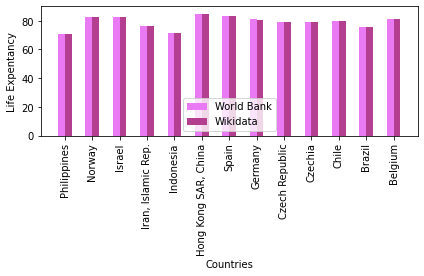

In [35]:
query = """
PREFIX wb: <http://worldbank.org/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?country_code ?country_name ?year (AVG(?year_exp_WB) AS ?exp_wb) (AVG(?year_exp) AS ?exp_wiki)
WHERE {
    ?country a wb:Country .
    ?country dc:identifier ?country_code .
    ?country rdfs:label ?country_name.
    ?country owl:sameAs ?sameAsCountry .
    ?country wb:hasAnnualIndicatorEntry ?annualIndicator .
    ?annualIndicator wb:hasIndicator <http://worldbank.org/Indicator/SP.DYN.LE00.IN> .
    ?annualIndicator owl:hasValue ?year_exp_WB .
    ?annualIndicator time:year ?year .
  
    ?sameAsCountry p:P2250 ?itemLifeExpectancy .
    ?itemLifeExpectancy ps:P2250 ?year_exp .
    ?itemLifeExpectancy pq:P585 ?time .
    BIND(year(?time) AS ?year)
    FILTER(?year=2017)
}
GROUP BY ?country_code ?country_name ?year
ORDER BY ?country_code
"""
query_result = run_query(query, config=config, join_stars_locally=False)  # executing query with DeTrusty

data = []
labels = []
wb = []
wikidata = []
headers = ["Country Code","Country Name","Year","Life Expectancy by World Bank","Life Expectancy by Wikidata"]
for row in query_result['results']['bindings']:
    data.append([row['country_code']['value'],row['country_name']['value'],row['year']['value'],row['exp_wb']['value'],row['exp_wiki']['value']])
    labels.append(row['country_name']['value'])
    wb.append(float(row['exp_wb']['value']))
    wikidata.append(float(row['exp_wiki']['value']))
print(tabulate(data, headers=headers))

x = np.arange(len(labels))
width = 0.5  
fig, ax = plt.subplots()
rects1 = ax.bar(2*x - width/2, wb, width, label='World Bank', color=["#EA7AF4"])
rects2 = ax.bar(2*x + width/2, wikidata, width, label='Wikidata', color=["#B43E8F"])
ax.set_ylabel('Life Expentancy')
ax.set_xlabel('Countries')
ax.set_xticks(2*x, labels, rotation=90)
#ax.set_yticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0], ["0.0","0.5","1.0","1.5","2.0","2.5","3.0","3.5","4.0","4.5","TimeOut"])
ax.set_ylim(0,90)
ax.legend(loc=8)
fig.tight_layout()

plt.show()

### Query 2: Number of conflicts and fatalities per million per year in Ukraine

2024-03-21 16:37:53,800 - DeTrusty.Wrapper.RDFWrapper - INFO - Contacting endpoint: https://query.wikidata.org/sparql
2024-03-21 16:37:53,808 - DeTrusty.Wrapper.RDFWrapper - INFO - Contacting endpoint: https://skynet.coypu.org/coypu-internal


  Year    Number of Events    Fatalities per Million
------  ------------------  ------------------------
  2022               40488                   801.145


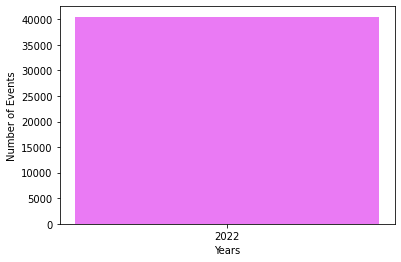

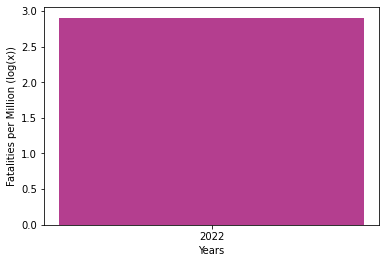

In [36]:
query = """
PREFIX coy: <https://schema.coypu.org/global#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>

SELECT ?year (COUNT(?iri) AS ?no_of_events)  ((SUM(?fatalities)/AVG(?population))*1000000 AS ?fatalities_per_million)
WHERE {
    ?iri a coy:Conflict .
    ?iri coy:hasCountryLocation ?code_uri .
    ?code_uri coy:hasIsoCode 'UKR' .
    ?iri coy:hasTimestamp ?timestamp .
    ?iri coy:hasFatalities ?fatalities .
    BIND(year(?timestamp) as ?year)
    
    ?countryWiki wdt:P298 'UKR' .
    ?countryWiki p:P1082 ?itemP .
    ?itemP pq:P585 ?time .
    ?itemP ps:P1082 ?population .
    BIND(year(?time) as ?year)
}
GROUP BY ?year
ORDER BY ?year
"""
query_result = run_query(query, config=config, join_stars_locally=False)  # executing query with DeTrusty

data = []
labels = []
events = []
fatalities = []
headers = ["Year","Number of Events","Fatalities per Million"]
for row in query_result['results']['bindings']:
    data.append([row['year']['value'],row['no_of_events']['value'],row['fatalities_per_million']['value']])
    labels.insert(0,row['year']['value'])
    events.insert(0,int(row['no_of_events']['value']))
    fatalities.insert(0,float(row['fatalities_per_million']['value']))
print(tabulate(data, headers=headers))
plt.bar(labels, events, color=["#EA7AF4"])
plt.xlabel("Years")
plt.ylabel("Number of Events")
plt.show()
plt.bar(labels, np.log10(fatalities), color=["#B43E8F"])
plt.xlabel("Years")
plt.ylabel("Fatalities per Million (log(x))")
plt.show()

### Query 3: GDP per capita and carbon emission per capita for Germany per year

2024-03-21 16:39:35,738 - DeTrusty.Wrapper.RDFWrapper - INFO - Contacting endpoint: https://labs.tib.eu/sdm/worldbank_endpoint/sparql
2024-03-21 16:39:38,529 - DeTrusty.Wrapper.RDFWrapper - INFO - Contacting endpoint: https://query.wikidata.org/sparql
2024-03-21 16:39:41,203 - DeTrusty.Wrapper.RDFWrapper - INFO - Contacting endpoint: https://query.wikidata.org/sparql


  Year    GDP per Capita [US$]    Carbon per Capita [kg]
------  ----------------------  ------------------------
  2019                 46763.2                  16274
  2018                 47931.2                  16203.1
  2017                 44632.1                  15843.1
  2016                 42047.8                  15580.7
  2015                 41080.7                  15685.4
  2014                 47964                    15904.6
  2012                 43815.4                  15598.2
  2010                 41585.2                  14490.2
  2008                 45672.8                  13600.9
  2006                 36381                    12816.6
  2004                 34112.9                  11745.5
  2002                 25182.4                  10559.7
  2000                 23680.8                  10225.9
  1998                 27292.4                   9938.92
  1996                 30449.7                   9687.01
  1994                 27043.1                

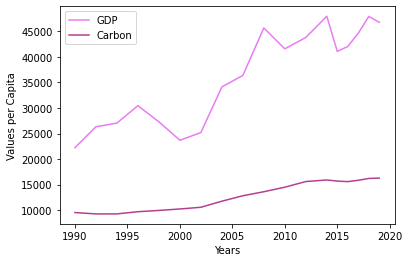

In [37]:
query = """
PREFIX wb: <http://worldbank.org/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT ?year (AVG(?value/?population) AS ?gdp_per_capita) (AVG(?value1/?population)*1000000 AS ?carbon_per_capita)
WHERE {
    ?indicator a wb:AnnualIndicatorEntry .
    ?indicator wb:hasIndicator <http://worldbank.org/Indicator/NY.GDP.MKTP.CD> .
    ?indicator wb:hasCountry ?country .
    ?indicator owl:hasValue ?value .
    ?indicator time:year ?year .
    ?country <http://purl.org/dc/elements/1.1/identifier> 'DEU' .
    
    ?indicator1 a wb:AnnualIndicatorEntry .
    ?indicator1 wb:hasIndicator <http://worldbank.org/Indicator/EN.ATM.CO2E.KT> .
    ?indicator1 wb:hasCountry ?country1 .
    ?indicator1 owl:hasValue ?value1 .
    ?indicator1 time:year ?year .
    ?country <http://purl.org/dc/elements/1.1/identifier> 'DEU' .   
    
    ?countryWiki wdt:P298 'DEU' .
    ?countryWiki p:P1082 ?itemP .
    ?itemP pq:P585 ?time.
    ?itemP ps:P1082 ?population .
    BIND(year(?time) AS ?year)
}
GROUP BY ?year
ORDER BY ?year
"""
query_result = run_query(query, config=config, join_stars_locally=False)  #executing query with DeTrusty

data = []
labels = []
gdp = []
carbon = []
headers = ["Year","GDP per Capita [US$]","Carbon per Capita [kg]"]
for row in query_result['results']['bindings']:
    data.append([row['year']['value'],row['gdp_per_capita']['value'],row['carbon_per_capita']['value']])
    labels.insert(0,int(row['year']['value']))
    gdp.insert(0,float(row['gdp_per_capita']['value']))
    carbon.insert(0,float(row['carbon_per_capita']['value']))
print(tabulate(data, headers=headers))

plt.plot(labels, gdp, label='GDP', color="#EA7AF4")
plt.plot(labels, carbon, label='Carbon', color="#B43E8F")

plt.xlabel('Years')
plt.ylabel('Values per Capita')

plt.legend()

plt.show()

---

## References

<a name="1">\[1\]</a> SPARQL Specification. 2008. URL: [https://www.w3.org/TR/2008/REC-rdf-sparql-query-20080115/](https://www.w3.org/TR/2008/REC-rdf-sparql-query-20080115/).

<a name="2">\[2\]</a> RDF Specification. 2004. URL: [https://www.w3.org/TR/2004/REC-rdf-primer-20040210/](https://www.w3.org/TR/2004/REC-rdf-primer-20040210/).

<a name="3">\[3\]</a> SHACL Specification. 2017. URL: [https://www.w3.org/TR/2017/REC-shacl-20170720/](https://www.w3.org/TR/2017/REC-shacl-20170720/).

<a name="4">\[4\]</a> ODRL Specification. 2018. URL: [https://www.w3.org/TR/2018/REC-odrl-model-20180215/](https://www.w3.org/TR/2018/REC-odrl-model-20180215/).

<a name="5">\[5\]</a> J. Corman, J.L. Reutter, O. Savković. Semantics and Validation of Recursive SHACL. In: The Semantic Web – ISWC 2018, Springer, Cham, Switzerland, 2018. DOI: [10.1007/978-3-030-00671-6_19](https://doi.org/10.1007/978-3-030-00671-6_19).

<a name="6">\[6\]</a> A. Dimou, M. Vander Sande, P. Colpaert, R. Verborgh, E. Mannes, R. Van de Walle. RML: A Generic Language for Integrated RDF Mappings of Heterogeneous Data. In: Proceedings of the Workshop on Linked Data on the Web co-located with WWW, CEUR-WS, Aachen, Germany, 2014. URL: [https://ceur-ws.org/Vol-1184/ldow2014_paper_01.pdf](https://ceur-ws.org/Vol-1184/ldow2014_paper_01.pdf).

<a name="7">\[7\]</a> E. Iglesias, S. Jozashoori, D. Chaves-Fraga, D. Collarana, M.-E. Vidal. SDM-RDFizer: An RML Interpreter for the Efficient Creation of RDF Knowledge Graphs. In: CIKM ’20:Proceedings of the 29th ACM International Conference on Information & Knowledge Management, ACM, New York, NY, USA, 2020. DOI: [10.1145/3340531.3412881](https://doi.org/10.1145/3340531.3412881).

<a name="8">\[8\]</a> M. Figuera, P.D. Rohde, M.-E. Vidal. Trav-SHACL: Efficiently Validating Networks of SHACL Constraints. In: The Web Conference, ACM, New York, NY, USA, 2021. DOI: [10.1145/3442381.3449877](https://doi.org/10.1145/3442381.3449877).

<a name="9">\[9\]</a> P.D. Rohde. DeTrusty v0.11.3. 2023. DOI: [10.5281/zenodo.7871295](https://doi.org/10.5281/zenodo.7871295).

<a name="10">\[10\]</a> P.D. Rohde, E. Iglesias, M.-E. Vidal. SHACL-ACL: Access Control with SHACL. In: The Semantic Web: ESWC 2023 Satellite Events, Springer, Cham, 2023. DOI: [https://doi.org/10.1007/978-3-031-43458-7_4](https://doi.org/https://doi.org/10.1007/978-3-031-43458-7_4). Demo: [SDM-TIB/SHACL-ACL](https://github.com/SDM-TIB/SHACL-ACL).